# Scattering sequential model
* based upon: https://www.kymat.io/gallery_1d/plot_classif_torch.html#sphx-glr-gallery-1d-plot-classif-torch-py

* This implementation focus on a channel based implementation, keeping the original shape (num_measurements, 5000, 12) 
* now also keeping the original scattering result without calculating the mean

In [499]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from utilities.utils import CustomDataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

In [500]:
import utilities.data_loader as data_loader
import utilities.filter_data as filter_data
import importlib
importlib.reload(data_loader)
importlib.reload(filter_data)

<module 'utilities.filter_data' from '/mnt/c/Users/phil/university/verona/visual-intelligence-ecg-project/utilities/filter_data.py'>

## Loading Data

In [501]:
data_path = "data/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/"
ecg_data_path = data_path + "WFDBRecords/"

In [502]:
importlib.reload(data_loader)
# data = data_loader.load_number_of_random_samples(ecg_data_path, 1000)
data = data_loader.load_number_of_random_samples_balanced(ecg_data_path, 2000)

Loaded 2000 of 2000


In [503]:
healty_samples = [entry for entry in data if entry['binary_label'] == 0]
unhealty_samples = [entry for entry in data if entry['binary_label'] == 1]
print(f"Number of healty samples: {len(healty_samples)}")
print(f"Number of unhealty samples: {len(unhealty_samples)}")

Number of healty samples: 1000
Number of unhealty samples: 1000


In [504]:
# count how many nan in X
X = np.array([entry['data'] for entry in data], dtype=np.float32)
print(np.isnan(X).sum())

23


In [505]:
X = np.nan_to_num(X)
y = np.array([entry['binary_label'] for entry in data], dtype=np.float32)
print(X.shape)
print(y.shape)

(2000, 5000, 12)
(2000,)


In [506]:
# make sure no nan values
if np.isnan(X).any():
    print("!!!X contains NaN!!!")
else:
    print("X does not contain NaN")

X does not contain NaN


## Filtering Data

In [507]:
# remove baseline wander using DWT
for index in range(X.shape[0]):
    if index % 10 == 0 or index == X.shape[0] - 1:
        clear_output(wait=True)
        print(f"Removing baseline wander sample {index + 1}/{X.shape[0]}")
    for channel in range(X.shape[2]):
        X[index, :, channel] = filter_data.apply_dwt_to_eliminate_baseline_wander(X[index, :, channel], hard_threshold=True)
        # X[index, :, channel] = filter_data.fir_filter_to_eliminate_baseline_wander(X[index, :, channel])  # to slow...
print("Count nan: ", np.isnan(X).sum())

Removing baseline wander sample 2000/2000
Count nan:  0


In [508]:
# remove power line interference using notch filter
for index in range(X.shape[0]):
    if index % 50 == 0 or index == X.shape[0] - 1:
        clear_output(wait=True)
        print(f"Removing power line interference sample {index + 1}/{X.shape[0]}")
    for channel in range(X.shape[2]):
        X[index, :, channel] = filter_data.apply_notch_filter(X[index, :, channel])
print("Count nan: ", np.isnan(X).sum())

Removing power line interference sample 2000/2000
Count nan:  0


In [509]:
# for index in range(X.shape[0]):
#     if index % 50 == 0 or index == X.shape[0] - 1:
#         clear_output(wait=True)
#         print(f"Adding noise to sample {index + 1}/{X.shape[0]}")
#     for channel in range(X.shape[2]):
#         X[index, :, channel] = filter_data.add_noise_to_signal(X[index, :, channel])
# print("Count nan: ", np.isnan(X).sum())

In [510]:
# TODO: some issues with infinity, fix...
# remove EMG noise and electrode motion artifacts using adaptive filter
# for index in range(X.shape[0]):
#     if index % 20 == 0 or index == X.shape[0] - 1:
#         clear_output(wait=True)
#         print(f"Removing EMG noise sample {index + 1}/{X.shape[0]}")
#     for channel in range(X.shape[2]):
#         X[index, :, channel] = filter_data.apply_adaptive_filter(X[index, :, channel])

In [511]:
# TODO: read this!!! https://www.researchgate.net/publication/347930656_Comparative_Study_on_the_Effect_of_Order_and_Cut_off_Frequency_of_Butterworth_Low_Pass_Filter_for_Removal_of_Noise_in_ECG_Signal
# cutoff_frequency = 50  # TODO: find good value
# for index in range(X.shape[0]):
#     if index % 50 == 0 or index == X.shape[0] - 1:
#         clear_output(wait=True)
#         print(f"Filtering sample {index + 1}/{X.shape[0]}")
#     for channel in range(X.shape[2]):
#         X[index, :, channel] = filter_data.apply_low_pass_filter(X[index, :, channel], cutoff_frequency)

In [512]:
# TODO: implement LOESS filter?!

In [513]:
print(np.isnan(X).sum())

0


## Data into dataset

In [617]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1905)

# make sure mean zero and unit variance
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
# X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# scale each channel on its own:
for channel in range(X_train.shape[2]):
    scaler = StandardScaler()
    X_train[:,:,channel] = scaler.fit_transform(X_train[:,:,channel])
    X_test[:,:,channel] = scaler.transform(X_test[:,:,channel])

print(X_train.shape)

(1600, 5000, 12)


## Model

In [618]:
import torch
from torch.nn import Linear, NLLLoss, LogSoftmax, Sequential
from torch.optim import Adam
from sklearn.metrics import confusion_matrix
from kymatio.torch import Scattering1D
from kymatio.datasets import fetch_fsdd

In [619]:
# TODO: implement cuda!
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(1905)
if use_cuda:
    print("Using GPU")

Using GPU


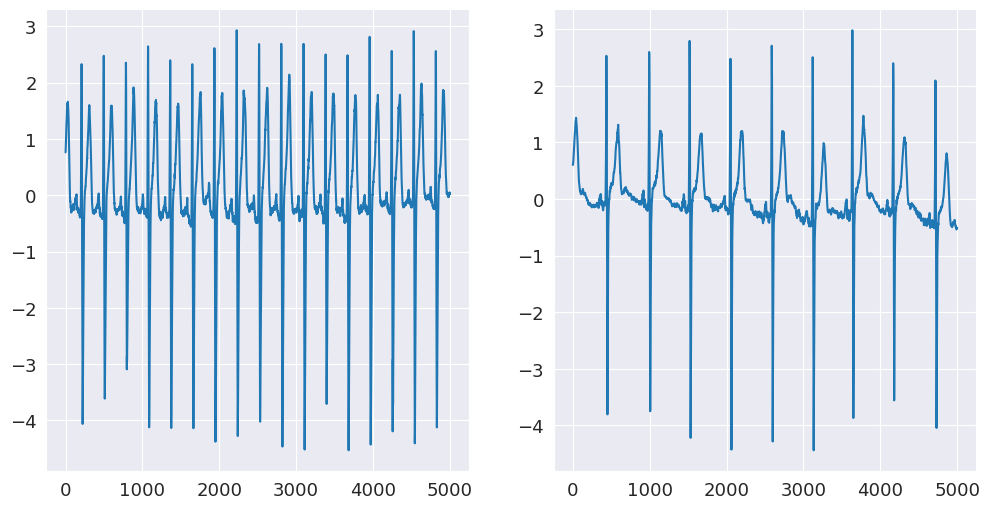

In [620]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(X_train[0, :, 7])
plt.subplot(1,2,2)
plt.plot(X_train[1, :, 7])
plt.show()

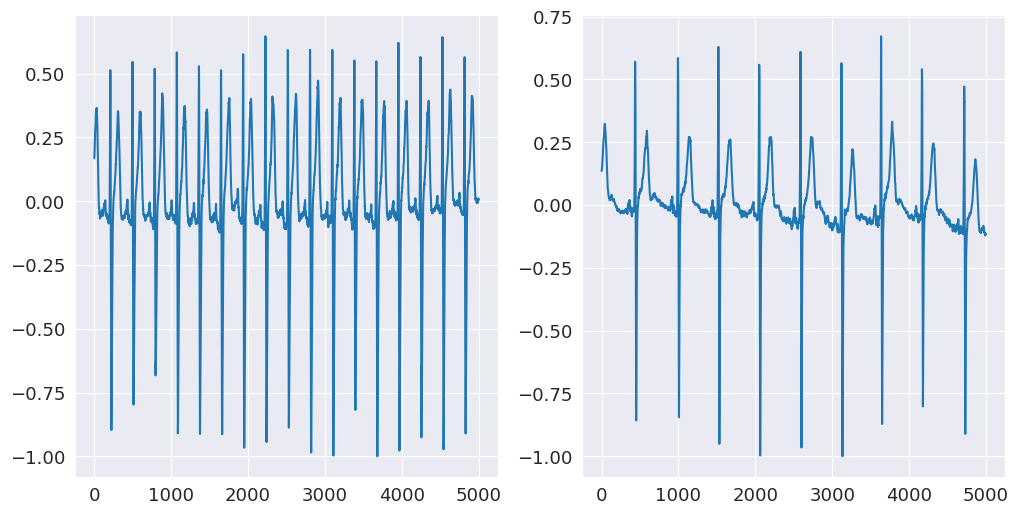

In [621]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(X_train[0, :, 7] / np.max(np.abs(X_train[0, :, 7])))
plt.subplot(1,2,2)
plt.plot(X_train[1, :, 7] / np.max(np.abs(X_train[1, :, 7])))
plt.show()

In [622]:
print(X_train.shape)

(1600, 5000, 12)


In [623]:
T = X_train.shape[1]
# T = 2**J
# TODO: find good values, maybe increase Q
J = 8
Q = 16
log_eps = 1e-6
# scattering = Scattering1D(J, T, Q).to(device)
# scattering = Scattering1D(J, shape=X_train.shape[1], T=T, Q=Q).to(device)
# scattering = Scattering1D(J=10, shape=X_train.shape[1], Q=20).to(device)
scattering = Scattering1D(J=8, shape=X_train.shape[1], Q=8).to(device)

In [624]:
scattering_apply_log = True
scattering_normalize = True
scatering_use_mean = False
scattering_standardscale_result = False

### Train set

In [625]:
# TODO: move scattering into nn module class
scattering_results_np = []
standard_scaler_per_channel = []
for channel in range(X_train.shape[2]):
    clear_output(wait=True)
    print(f"Scattering channel {channel + 1}/{X_train.shape[2]}")
    
    value = np.ascontiguousarray(X_train[:, :, channel])
    # normalize value
    if scattering_normalize:
        value /= np.max(np.abs(value))
    
    scattering_result = scattering.forward(torch.from_numpy(value).to(device))
    # scattering_result = scattering_result[:, 1:,:]  # remove zeroth order scattering coefficients
    scattering_result = scattering_result.double()
    
    # for preventing small values
    if scattering_apply_log:
        scattering_result = torch.log(torch.abs(scattering_result) + log_eps)
    if scatering_use_mean:
        scattering_result = torch.mean(scattering_result, dim=-1)
    scattering_result = torch.Tensor.cpu(scattering_result)
    
    
    # standard scaler
    # TODO: is this required? kinda weird, scaling data here again results in train accuracy of 1.0, kinda overfitting. Without scaling, train accuracy is below 0.7 but increases very slowly, no strong overfitting.
    # probably dont use for now?
    # TODO: still not sure...
    if scattering_standardscale_result:
        scaler = StandardScaler()
        scattering_result = scaler.fit_transform(scattering_result)
        standard_scaler_per_channel.append(scaler)
    
    scattering_results_np.append(scattering_result)

Scattering channel 12/12


In [626]:
scattering_results_np = np.array(scattering_results_np)
print(scattering_results_np.shape)

(12, 1600, 234, 19)


In [627]:
# scattering_results_np = scattering_results_np.reshape(scattering_results_np.shape[1], scattering_results_np.shape[0], scattering_results_np.shape[2], scattering_results_np.shape[3])
scattering_results_np = scattering_results_np.reshape(scattering_results_np.shape[1], scattering_results_np.shape[0], scattering_results_np.shape[2], scattering_results_np.shape[3])
print(scattering_results_np.shape)
if np.isnan(scattering_results_np).any():
    print("!!!Scattering results contains NaN!!!")
else:
    print("Scattering results does not contain NaN")

(1600, 12, 234, 19)
Scattering results does not contain NaN


In [628]:
meta = scattering.meta()
order1 = np.where(meta['order'] == 1)

In [629]:
scattering_results_np[0, 1, order1].shape

(1, 54, 19)

In [630]:
# plt.figure(figsize=(12,6))
# plt.subplot(1,2,1)
# plt.imshow(scattering_results_np[0, 1, order1])
# plt.subplot(1,2,2)
# plt.imshow(scattering_results_np[1, 1, order1])
# plt.show()

In [631]:
# turn into torch
scattering_results = torch.from_numpy(scattering_results_np)
print("shape: ", scattering_results.shape)
if torch.isnan(scattering_results).any().item():
    print("!!!Scattering results contains NaN!!!")
else:
    print("Scattering results does not contain NaN")
    
# turn y_train into tensor
y_tensor = torch.tensor(y_train, dtype=torch.long)

shape:  torch.Size([1600, 12, 234, 19])
Scattering results does not contain NaN


### Test set

In [632]:
test_scattering_results_np = []
for channel in range(X_test.shape[2]):
    clear_output(wait=True)
    print(f"Scattering channel {channel + 1}/{X_test.shape[2]}")
    
    value = np.ascontiguousarray(X_train[:, :, channel])
    # normalize value
    if scattering_normalize:
        value /= np.max(np.abs(value))
    
    scattering_result = scattering.forward(torch.from_numpy(value).to(device))
    # scattering_result = scattering_result[:, 1:,:]  # remove zeroth order scattering coefficients
    scattering_result = scattering_result.double()
    
    
    if scattering_apply_log:
        scattering_result = torch.log(torch.abs(scattering_result) + log_eps)
    if scatering_use_mean:
        scattering_result = torch.mean(scattering_result, dim=-1)
    scattering_result = torch.Tensor.cpu(scattering_result)
    
    # only scale if train data was also scaled
    if standard_scaler_per_channel is not None and len(standard_scaler_per_channel) > 0:
        scattering_result = standard_scaler_per_channel[channel].transform(scattering_result)
    
    test_scattering_results_np.append(scattering_result)

test_scattering_results_np = np.array(test_scattering_results_np)

# test_scattering_results_np = test_scattering_results_np.reshape(test_scattering_results_np.shape[1], test_scattering_results_np.shape[0], test_scattering_results_np.shape[2], test_scattering_results_np.shape[3])
test_scattering_results_np = test_scattering_results_np.reshape(test_scattering_results_np.shape[1], test_scattering_results_np.shape[0], test_scattering_results_np.shape[2], test_scattering_results_np.shape[3])
print(test_scattering_results_np.shape)
if np.isnan(test_scattering_results_np).any():
    print("!!!Scattering results contains NaN!!!")
else:
    print("Scattering results does not contain NaN")

# turn into torch
test_scattering_results = torch.from_numpy(test_scattering_results_np)
print("shape: ", test_scattering_results.shape)
if torch.isnan(test_scattering_results).any().item():
    print("!!!Scattering results contains NaN!!!")
else:
    print("Scattering results does not contain NaN")

test_y_tensor = torch.tensor(y_test, dtype=torch.long)

Scattering channel 12/12
(1600, 12, 234, 19)
Scattering results does not contain NaN
shape:  torch.Size([1600, 12, 234, 19])
Scattering results does not contain NaN


In [633]:
# plt.figure(figsize=(12,6))
# plt.subplot(1,2,1)
# plt.plot(test_scattering_results_np[0, 7, :])
# plt.subplot(1,2,2)
# plt.plot(test_scattering_results_np[2, 7, :])
# plt.show()

In [634]:
print(scattering_results.shape)

torch.Size([1600, 12, 234, 19])


In [635]:
# using only one channel
# scattering_results = scattering_results[:,9,:,:].reshape(scattering_results.shape[0],1, scattering_results.shape[2],scattering_results.shape[3])
# test_scattering_results = test_scattering_results[:,9,:,:].reshape(test_scattering_results.shape[0],1, test_scattering_results.shape[2],test_scattering_results.shape[3])

In [636]:
import model.MultiTimeSeriesToBinary_v3 as MultiTimeSeriesToBinary_v2
importlib.reload(MultiTimeSeriesToBinary_v2)

<module 'model.MultiTimeSeriesToBinary_v3' from '/mnt/c/Users/phil/university/verona/visual-intelligence-ecg-project/model/MultiTimeSeriesToBinary_v3.py'>

In [637]:
num_time_series = scattering_results.shape[1]
series_shape = (scattering_results.shape[2], scattering_results.shape[3])  #, scattering_results.shape[3])
num_classes = 2


In [638]:
# Number of signals to use in each gradient descent step (batch).
batch_size = 64
# Number of epochs.
num_epochs = 400

In [639]:
validation_X = scattering_results[-30:]
validation_y = y_tensor[-30:]
scattering_results = scattering_results[:-30]
y_tensor = y_tensor[:-30]
dataset_train = CustomDataset(scattering_results, y_tensor)
dataset_test = CustomDataset(test_scattering_results, test_y_tensor)
dataset_validation = CustomDataset(validation_X, validation_y)

trainset = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)  # , shuffle=True
testset = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)
validationset = DataLoader(dataset_validation, batch_size=batch_size, shuffle=False)

In [640]:
nsamples = scattering_results.shape[0]
nbatches = nsamples // batch_size

print("nsamples: ", nsamples)
print("nbatches: ", nbatches)
print("num_time_series: ", num_time_series)
print("series_shape: ", series_shape)
print("num_classes: ", num_classes)

nsamples:  1570
nbatches:  24
num_time_series:  12
series_shape:  (234, 19)
num_classes:  2


In [641]:
scattering_results[0].shape

torch.Size([12, 234, 19])

In [651]:
importlib.reload(MultiTimeSeriesToBinary_v2)

# Learning rate for Adam.
num_epochs = 2000
lr = 1e-4
model = MultiTimeSeriesToBinary_v2.MultiTimeSeriesToBinary_v2(num_time_series, series_shape, batch_size, num_classes).double()  # somehow needs .double at the end, bit weird
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # , weight_decay=0.03  -> with weight decay accuracy does not change
# optim = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-6, momentum=0.9, nesterov=True)

sample_weight = None
criterion = torch.nn.CrossEntropyLoss(weight=torch.Tensor(sample_weight).double() if sample_weight is not None else None)  # seems to be better than NLLLoss

# criterion = torch.nn.NLLLoss()
# criterion = torch.nn.BCEWithLogitsLoss()
# criterion = torch.nn.BCELoss()


model = model.to(device)
criterion = criterion.to(device)

best_acc = 0
best_epoch = 0

losses_train = []
losses_test = []
all_acc_train = []
all_acc_test = []

counter_with_no_acc_improve = 0
early_stopping_after = 50

pred_label_train = torch.empty((0)).to(device)    # .to(device) to move the data/model on GPU or CPU (default)
true_label_train = torch.empty((0)).to(device)

for epoch in range(num_epochs):
    model.train()

    # For each batch, calculate the gradient with respect to the loss and take
    # one step.
    for data_tr in trainset:
        # move batch to GPU
        data_tr[0] = data_tr[0].to(device)
        # print("data tr 0: ", data_tr[0])
        data_tr[1] = data_tr[1].to(device)
        # pred_y = model(scattering_results[idx])
        # model.zero_grad()
        pred_y = model.forward(data_tr[0].double())
        # print("scattering_results: ", scattering_results[idx].shape)
        # print("epoch prediction: ", pred_y)
        # print("max..: ", torch.max(pred_y,1))
        # print("true y: ", data_tr[1])
        
        
        # _, pred = pred_y.max(1)  # returns max_val, max_indices
        # _, pred = torch.max(pred_y,1)
        pred = pred_y.argmax(dim=1)
        pred_label_train = torch.cat((pred_label_train,pred),dim=0)
        true_label_train = torch.cat((true_label_train,data_tr[1]),dim=0)
        
        
        loss = criterion(pred_y, data_tr[1])
        
        optim.zero_grad()  # clear gradients
        loss.backward() # backpropagation
        optim.step() # apply gradients, update weights
    
    acc_t = accuracy_score(true_label_train.cpu(),pred_label_train.cpu())

    model.eval()

    all_predictions = []
    for data_test in testset:
        data_test[0] = data_test[0].to(device)
        # with torch.no_grad():
        #     pred_y = model.forward(data_test[0].double())
        pred_y = model.forward(data_test[0].double())
        # _, pred = pred_y.max(1)
        # _, pred = torch.max(pred_y,1)
        pred = pred_y.argmax(dim=1)
        all_predictions.extend(pred.cpu().numpy())
    acc_test = accuracy_score(y_test, all_predictions)    
    
    all_acc_train.append(acc_t)
    all_acc_test.append(acc_test)
    
    
    print("  epoch : {}/{}, loss = {:.4f} - acc train = {:.4f} - acc test = {:.4f}".format(epoch + 1, num_epochs, loss, acc_t, acc_test))
    
    if acc_test > best_acc:
        print("  Saving model with accuracy: {:.4f}".format(acc_test))
        best_acc = acc_test
        best_epoch = epoch
        torch.save(model.state_dict(), 'models_trained/MultiTimeSeriesToBinary_model.pth')
        counter_with_no_acc_improve = 0
    else:
        counter_with_no_acc_improve += 1
        if counter_with_no_acc_improve > early_stopping_after:
            print("  Early stopping after {} epochs without accuracy improvement".format(early_stopping_after))
            break
    
    # Reinitialize for acc calculation !!!
    pred_label_train = torch.empty((0)).to(device)    # .to(device) to move the data/model on GPU or CPU (default)
    true_label_train = torch.empty((0)).to(device)
    
    # # # TODO: need to call model.eval here?
    # model.eval()  # needed if dropout is used
    # resp = model.forward(scattering_results)
    # # print("resp: ", resp)
    # # print("y_tensor: ", y_tensor)
    # avg_loss = criterion(resp, y_tensor)
    # y_hat = resp.argmax(dim=1)
    # accuracy = (y_tensor == y_hat).float().mean()
    # 
    # acc_train.append(accuracy)
    # losses_train.append(avg_loss)
    # print("  epoch : {}/{}, loss = {:.4f} - acc train = {:.4f}".format(epoch + 1, num_epochs, avg_loss, accuracy))
    
    
    # 
    #     
    # # Test set
    # resp = model.forward(test_scattering_results)
    # avg_loss_test = criterion(resp, test_y_tensor)
    # y_hat = resp.argmax(dim=1)
    # accuracy_test = (test_y_tensor == y_hat).float().mean()
    # acc_test.append(accuracy_test)
    # losses_test.append(avg_loss_test)
    # 
    # print("  epoch : {}/{}, loss = {:.4f} - acc train = {:.4f} - acc test = {:.4f}".format(epoch + 1, num_epochs, avg_loss, accuracy, accuracy_test))
    # 
    # # Save the model with best accuracy across the epoch
    # if accuracy_test > best_acc:
    #     print("  Saving model with test accuracy: {:.4f}".format(accuracy_test))
    #     best_acc = accuracy_test
    #     best_epoch = epoch
    #     torch.save(model.state_dict(), 'models_trained/MultiTimeSeriesToBinary_model.pth')
    #     counter_with_no_acc_improve = 0
    # else: 
    #     counter_with_no_acc_improve += 1
    #     if counter_with_no_acc_improve > early_stopping_after:
    #         print("  Early stopping after {} epochs without accuracy improvement".format(early_stopping_after))
    #         break
    
print('-'*30)
print('Best model test accuracy is {} at epoch {}/{}'.format(best_acc, best_epoch+1, num_epochs))

OutOfMemoryError: CUDA out of memory. Tried to allocate 140.00 MiB (GPU 0; 6.00 GiB total capacity; 4.85 GiB already allocated; 0 bytes free; 5.15 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# all_acc_train
# all_acc_test
plt.plot(all_acc_train)
plt.plot(all_acc_test)
plt.show()

## Validation

In [ ]:
best_model = MultiTimeSeriesToBinary_v2.MultiTimeSeriesToBinary_v2(num_time_series, series_shape, batch_size, num_classes).double()
best_model.load_state_dict(torch.load('models_trained/MultiTimeSeriesToBinary_model.pth'))
best_model = best_model.to(device)
best_model.eval()
# from torchinfo import summary
# print(summary(model))

In [ ]:
all_predictions = []
original_predictions = []
for data_test in validationset:
    data_test[0] = data_test[0].to(device)
    with torch.no_grad():
        pred_y = best_model.forward(data_test[0].double())
    _, pred = pred_y.max(1)
    original_predictions.extend(pred_y.cpu().numpy())
    all_predictions.extend(pred.cpu().numpy())

In [ ]:
print(original_predictions[:10])
print(all_predictions[:10])
print(y_test[:10])

In [ ]:
print("Accuracy: ", accuracy_score(validation_y, all_predictions))

In [ ]:
print(all_predictions.count(0))
print(all_predictions.count(1))

In [ ]:
print(list(validation_y).count(0))
print(list(validation_y).count(1))